# Camera calibration using CHARUCO

In [1]:
import numpy as np
import cv2, PIL, os
from cv2 import aruco
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib nbagg


## 1.  Marker dictionary creation

<IPython.core.display.Javascript object>


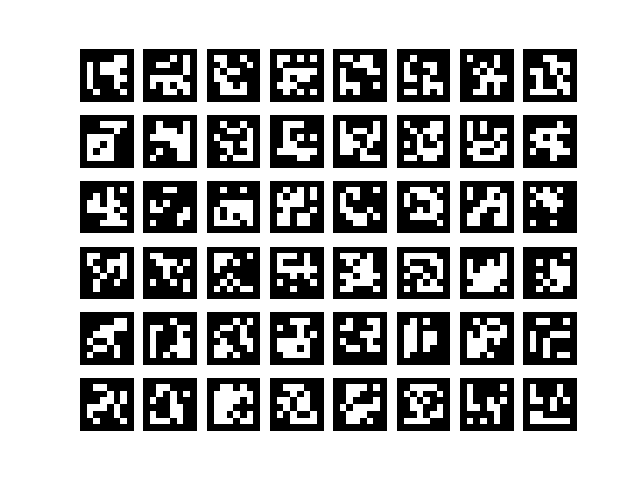

In [2]:
workdir = "data/"

aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)

fig = plt.figure()
nx = 8
ny = 6
for i in range(1, nx*ny+1):
    ax = fig.add_subplot(ny,nx, i)
    img = aruco.drawMarker(aruco_dict,i, 700)
    plt.imshow(img, cmap = mpl.cm.gray, interpolation = "nearest")
    ax.axis("off")

plt.savefig(workdir + "markers.pdf")    
plt.show()
#plt.close()

## 2. Camera pose estimation using CHARUCO chessboard

First, let's create the board.

<IPython.core.display.Javascript object>


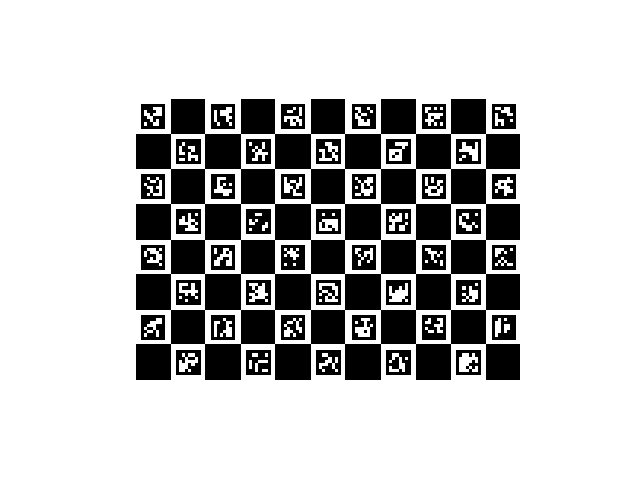

In [3]:
board = aruco.CharucoBoard_create(11, 8, 10, 7, aruco_dict)
imboard = board.draw((500, 500))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(imboard, cmap = mpl.cm.gray, interpolation = "nearest")
ax.axis("off")
plt.savefig(workdir + "chessboard.pdf")    
plt.show()


And take photos of it from multiple angles, for example:

<IPython.core.display.Javascript object>


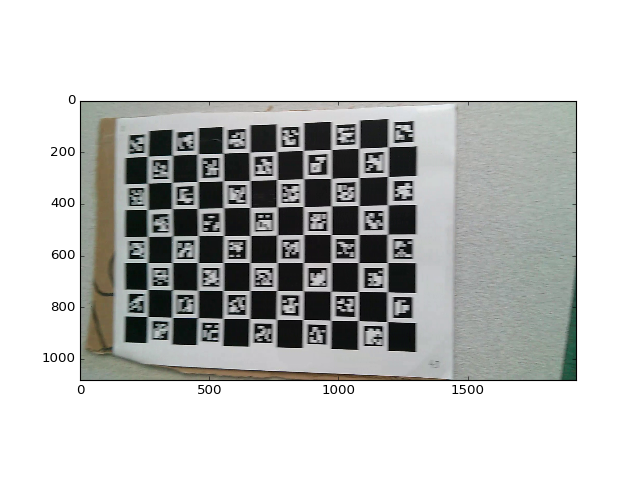

In [22]:
images = [workdir + f for f in os.listdir(workdir) if f.endswith(".png") and f.startswith("VID_20180314_141424")]

im = PIL.Image.open(images[10])
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(im)
#ax.axis('off')
plt.show()

Now, the camera calibration can be done using all the images of the chessboard. Two functions are necessary:

* The first will detect markers on all the images and.
* The second will proceed the detected markers to estimage the camera calibration data.

In [230]:
def read_chessboards(images):
    """
    Charuco base pose estimation.
    """
    print("POSE ESTIMATION STARTS:")
    allCorners = []
    allIds = []
    decimator = 0
    # SUB PIXEL CORNER DETECTION CRITERION
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.0001)

    for im in images:
        print("=> Processing image {0}".format(im))
        frame = cv2.imread(im)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)
        
        if len(corners)>0:
            # SUB PIXEL DETECTION
            for corner in corners:
                cv2.cornerSubPix(gray, corner, 
                                 winSize = (20,20), 
                                 zeroZone = (-1,-1), 
                                 criteria = criteria)
            res2 = cv2.aruco.interpolateCornersCharuco(corners,ids,gray,board)        
            if res2[1] is not None and res2[2] is not None and len(res2[1])>3 and decimator%1==0:
                allCorners.append(res2[1])
                allIds.append(res2[2])              
        
        decimator+=1   

    imsize = gray.shape
    return allCorners,allIds,imsize

In [231]:
#%%time

allCorners,allIds,imsize=read_chessboards(images)

POSE ESTIMATION STARTS:
=> Processing image data/VID_20180314_141424_290.png
=> Processing image data/VID_20180314_141424_335.png
=> Processing image data/VID_20180314_141424_175.png
=> Processing image data/VID_20180314_141424_260.png
=> Processing image data/VID_20180314_141424_370.png
=> Processing image data/VID_20180314_141424_30.png
=> Processing image data/VID_20180314_141424_5.png
=> Processing image data/VID_20180314_141424_320.png
=> Processing image data/VID_20180314_141424_150.png
=> Processing image data/VID_20180314_141424_265.png
=> Processing image data/VID_20180314_141424_210.png
=> Processing image data/VID_20180314_141424_85.png
=> Processing image data/VID_20180314_141424_250.png
=> Processing image data/VID_20180314_141424_165.png
=> Processing image data/VID_20180314_141424_255.png
=> Processing image data/VID_20180314_141424_55.png
=> Processing image data/VID_20180314_141424_195.png
=> Processing image data/VID_20180314_141424_200.png
=> Processing image data/VI

In [232]:
def calibrate_camera(allCorners,allIds,imsize):   
    """
    Calibrates the camera using the dected corners.
    """
    print("CAMERA CALIBRATION")
    
    cameraMatrixInit = np.array([[ 2000.,    0., imsize[0]/2.],
                                 [    0., 2000., imsize[1]/2.],
                                 [    0.,    0.,           1.]])

    distCoeffsInit = np.zeros((5,1))
    flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL) 
    (ret, camera_matrix, distortion_coefficients0, 
     rotation_vectors, translation_vectors,
     stdDeviationsIntrinsics, stdDeviationsExtrinsics, 
     perViewErrors) = cv2.aruco.calibrateCameraCharucoExtended(
                      charucoCorners=allCorners,
                      charucoIds=allIds,
                      board=board,
                      imageSize=imsize,
                      cameraMatrix=cameraMatrixInit,
                      distCoeffs=distCoeffsInit,
                      flags=flags,
                      criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))

    return ret, camera_matrix, distortion_coefficients0, rotation_vectors, translation_vectors

In [233]:
%time ret, mtx, dist, rvecs, tvecs = calibrate_camera(allCorners,allIds,imsize)

CAMERA CALIBRATION
CPU times: user 11.3 s, sys: 10.9 s, total: 22.2 s
Wall time: 5.78 s


In [234]:
ret

10.507478602319868

In [235]:
mtx

array([[1.82907422e+03, 0.00000000e+00, 9.70018381e+02],
       [0.00000000e+00, 1.82396375e+03, 5.64679336e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [236]:
dist

array([[ 5.77647646e+00],
       [-1.19867510e+02],
       [ 2.81138209e-03],
       [ 2.04931051e-02],
       [ 1.36665086e+03],
       [ 5.10336618e+00],
       [-1.13575351e+02],
       [ 1.33870881e+03],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00]])

### Check calibration results

<IPython.core.display.Javascript object>


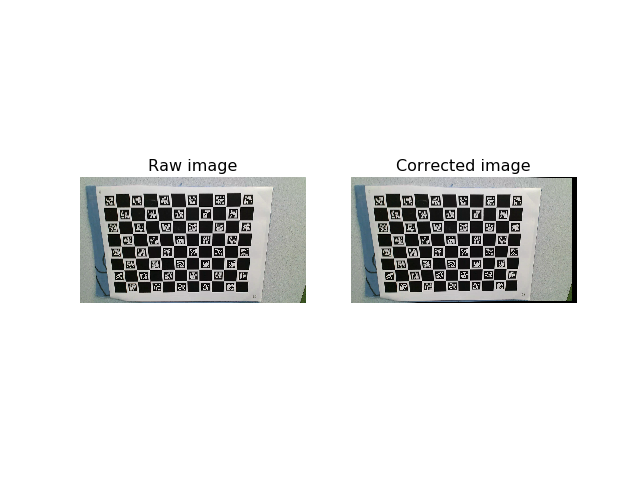

In [237]:
i=3 # select image id
plt.figure()
frame = cv2.imread(images[i])
img_undist = cv2.undistort(frame,mtx,dist,None)
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title("Raw image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(img_undist)
plt.title("Corrected image")
plt.axis("off")
plt.show()

## 3 . Use of camera calibration to estimate 3D translation and rotation of each marker on a scene

<IPython.core.display.Javascript object>


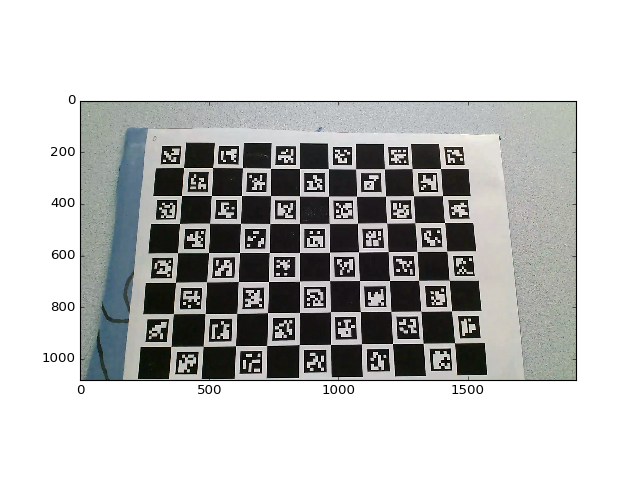

In [292]:

frame = cv2.imread("data/VID_20180314_141424_335.png")
#frame = cv2.undistort(src = frame, cameraMatrix = mtx, distCoeffs = dist)
plt.figure()
plt.imshow(frame, interpolation = "nearest")
plt.show()

## Post processing

In [293]:

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
parameters =  aruco.DetectorParameters_create()
corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, 
                                                      parameters=parameters)
# SUB PIXEL DETECTION
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.0001)
for corner in corners:
    cv2.cornerSubPix(gray, corner, winSize = (20,20), zeroZone = (-1,-1), criteria = criteria)
    
frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)

corners

[array([[[ 621.     ,  972.     ],
         [ 701.     ,  969.     ],
         [ 709.82715, 1049.7007 ],
         [ 619.     , 1055.     ]]], dtype=float32),
 array([[[ 847.2396 ,  945.72266],
         [ 969.38995,  943.80817],
         [ 971.123  , 1068.5813 ],
         [ 846.4021 , 1070.483  ]]], dtype=float32),
 array([[[244.78148, 828.47906],
         [341.     , 845.     ],
         [352.81595, 951.9142 ],
         [233.71716, 952.73145]]], dtype=float32),
 array([[[726.8156 , 822.9357 ],
         [848.2925 , 820.77747],
         [847.2396 , 945.72266],
         [723.4202 , 948.4776 ]]], dtype=float32),
 array([[[1464.    ,  834.    ],
         [1549.7858,  817.7192],
         [1562.2096,  936.4745],
         [1474.44  ,  916.0094]]], dtype=float32),
 array([[[1202.7676 ,  817.2212 ],
         [1318.0548 ,  817.4417 ],
         [1326.7908 ,  939.2189 ],
         [1209.4231 ,  940.84424]]], dtype=float32),
 array([[[1191.0787 ,  587.5763 ],
         [1302.4027 ,  587.67444],
      

Very fast processing !

## Results

<IPython.core.display.Javascript object>


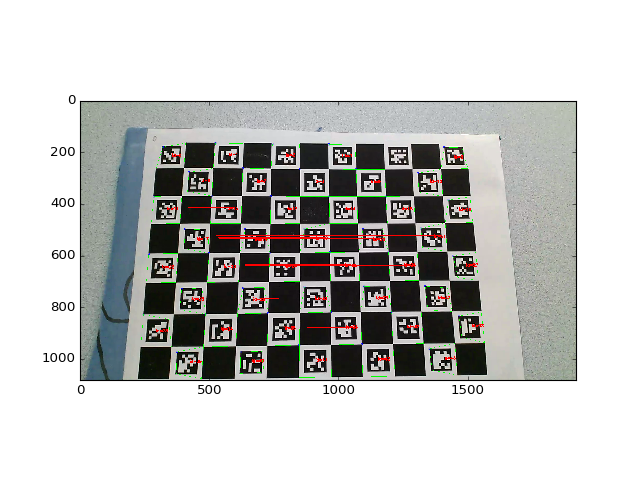

In [294]:
plt.figure()
plt.imshow(frame_markers, interpolation = "nearest")

plt.show()

### Add local axis on each marker

In [295]:
size_of_marker =  0.015 # side lenght of the marker in meter
rvecs,tvecs = aruco.estimatePoseSingleMarkers(corners, size_of_marker , mtx, dist)

In [296]:
length_of_axis = 0.01
imaxis = aruco.drawDetectedMarkers(frame.copy(), corners, ids)
for i in range(len(tvecs)):
    imaxis = aruco.drawAxis(imaxis, mtx, dist, rvecs[i], tvecs[i], length_of_axis)

<IPython.core.display.Javascript object>


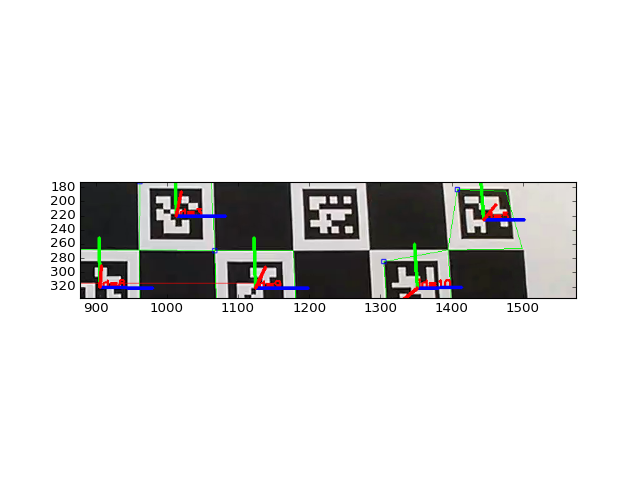

In [297]:
plt.figure()
plt.imshow(imaxis)
plt.show()

In [298]:
data = pd.DataFrame(data = tvecs.reshape(len(tvecs),3), columns = ["tx", "ty", "tz"], 
                    index = ids.flatten())
data.index.name = "marker"
data.sort_index(inplace= True)
data

tx        ty        tz
marker                              
0      -0.087532 -0.048772  0.257729
1      -0.054511 -0.047499  0.251998
2      -0.024629 -0.048055  0.257198
3       0.005991 -0.049758  0.268442
5       0.081431 -0.058824  0.326002
6      -0.079812 -0.038866  0.288858
7      -0.039313 -0.033350  0.250634
8      -0.008749 -0.032765  0.247373
9       0.020734 -0.033026  0.251473
10      0.061540 -0.039601  0.304885
11     -0.085302 -0.018672  0.244017
12     -0.053047 -0.018335  0.240409
13     -0.023604 -0.018494  0.243766
14      0.006463 -0.019159  0.253297
15      0.037312 -0.019558  0.260479
16      0.077235 -0.021539  0.296672
17     -0.083106 -0.003714  0.293096
18     -0.045454 -0.003068  0.284015
19     -0.007825 -0.003470  0.240971
20      0.025637 -0.003440  0.293119
21      0.062923 -0.005190  0.299281
22     -0.084038  0.010719  0.233880
23     -0.052517  0.010378  0.232546
24     -0.023112  0.010349  0.235414
25      0.006908  0.010603  0.246166
26      0.037766  0.010496  0.252274
27      0.079958  0.012114  0.291410
28     -0.086678  0.033446  0.295406
29     -0.044910  0.031067  0.274396
30     -0.009170  0.030199  0.270019
31      0.024675  0.029263  0.266069
32      0.064121  0.031595  0.293612
33     -0.086579  0.041780  0.231959
34     -0.050911  0.038219  0.218577
35     -0.022517  0.038873  0.225428
36      0.006988  0.039363  0.231235
37      0.036482  0.039194  0.234130
38      0.079325  0.045981  0.278108
39     -0.080389  0.065231  0.266857
40     -0.054088  0.077878  0.323161
41     -0.007729  0.053539  0.225587
42      0.022046  0.054264  0.231333
43      0.062683  0.063713  0.274862

In [301]:
v = data.loc[:6].values
((v[1:] - v[:-1])**2).sum(axis = 1)**.5

array([0.03353885, 0.03033577, 0.0326638 , 0.09532321, 0.16666463])

<IPython.core.display.Javascript object>


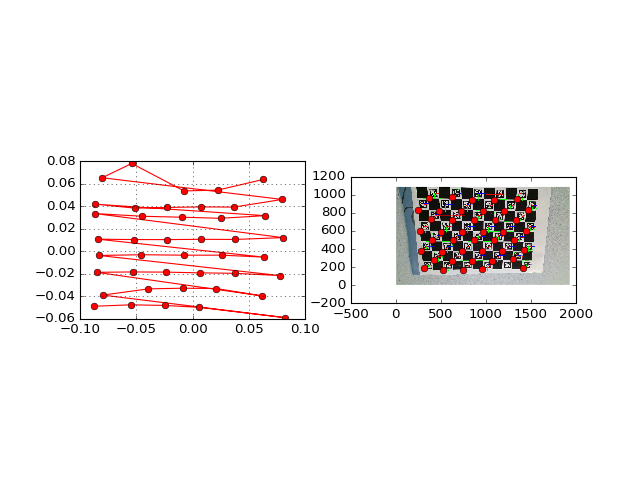

In [300]:
fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(1,2,1)
ax.set_aspect("equal")
plt.plot(data.tx, data.ty, "or-")
plt.grid()
ax = fig.add_subplot(1,2,2)
plt.imshow(imaxis, origin = "lower")
plt.plot(np.array(corners)[:, 0, 0,0], np.array(corners)[:, 0, 0,1], "or")
plt.show()

<IPython.core.display.Javascript object>


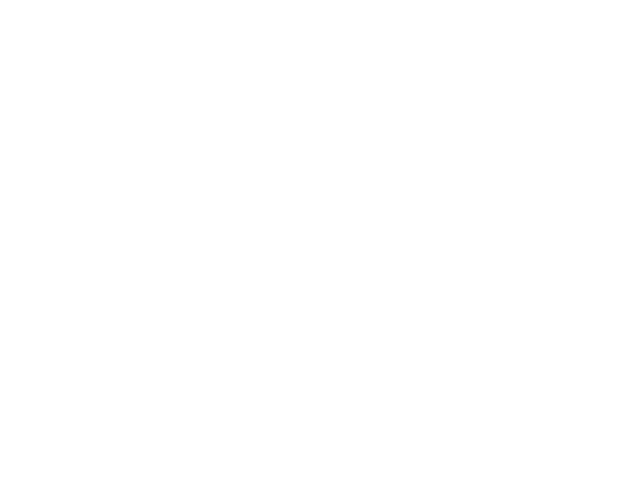

In [289]:
fig = plt.figure()


plt.show()


In [290]:
a = np.arange(50)
a

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [291]:
import pickle

In [273]:
f = open("truc.pckl", "wb")
pickle.dump(a, f)
f.close()

In [274]:
f = open("truc.pckl", "rb")
b = pickle.load(f)
b == a

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True], dtype=bool)

In [137]:
corners = np.array(corners)
data2 = pd.DataFrame({"px": corners[:, 0, 0, 1], 
                      "py": corners[:, 0, 0, 0]}, index = ids.flatten())
data2.sort_index(inplace=True)
data2

px           py
0   177.324295   222.723907
1   174.117722   448.426971
5   165.167435  1385.455933
6   292.872223   348.533112
7   290.211761   572.901550
8   286.861359   800.593140
9   285.043823  1029.405640
10  284.054932  1261.753418
11  406.743347   250.763550
12  405.577484   469.121307
13  402.066681   691.525330
14  398.973602   918.603577
16  397.476105  1371.831177
17  514.600769   374.230682
18  512.135010   590.534302
19  509.453247   809.594849
20  507.959595  1029.593262
21  507.521088  1253.295044
22  615.594482   280.054901
23  614.357056   490.602081
24  613.074951   704.512085
25  611.417297   922.586426
26  611.085632  1139.391602
27  611.036255  1359.634644
28  716.764465   397.975067
29  716.205688   606.338318
30  714.187927   817.897095
31  713.494141  1029.665405
32  713.155762  1244.999390
33  811.479309   305.960754
34  811.358704   509.836670
35  810.507996   716.540955
36  810.085144   926.713257
37  810.013611  1135.423462
38  810.014771  1347.564697
39  906.448242   420.143951
40  906.174988   621.917664
41  905.748413   825.513733
42  906.083923  1029.803955
43  906.387878  1237.707520

In [321]:
m0 = data2.loc[0]
m43 = data2.loc[43]
d01 = ((m0 - m43).values**2).sum()**.5
d = 42.5e-3 * (3.5**2 + 4.5**2)**.5
factor = d / d01
data2["x"] = data2.px * factor
data2["y"] = data2.py * factor
((data2[["x", "y"]].loc[11] - data2[["x", "y"]].loc[0]).values**2).sum()**.5


0.043476117957396747

In [347]:

c = np.array(corners).astype(np.float64).reshape(44,4,2)
(((c[:, 1:] - c[:, :-1])**2).sum(axis = 2)**.5).mean(axis =1)

array([ 138.33575835,  143.00113377,  142.012097  ,  140.69699432,
        146.66782406,  144.02442319,  138.67845434,  142.33812925,
        143.00229095,  140.33926025,  140.35356753,  146.66786569,
        139.34054504,  146.67222201,  140.03570454,  148.01939184,
        143.35647769,  142.67236143,  147.01931296,  148.02127735,
        137.67392157,  135.35308209,  141.00354688,  143.67946992,
        137.67149733,  138.67392207,  145.00112611,  142.33454105,
        138.3466791 ,  143.00234925,  139.0035972 ,  143.00115739,
        143.6865917 ,  144.67964727,  144.33446711,  141.67253496,
        143.67117097,  147.67232772,  150.35663387,  141.70034559,
        149.01342342,  146.01949591,  144.34013329,  150.35333222])

In [343]:
c

array([[[ 2406.,  1940.],
        [ 2546.,  1940.],
        [ 2545.,  2075.],
        [ 2405.,  2076.]],

       [[ 1991.,  1938.],
        [ 2138.,  1939.],
        [ 2138.,  2076.],
        [ 1993.,  2076.]],

       [[ 1584.,  1936.],
        [ 1728.,  1936.],
        [ 1731.,  2073.],
        [ 1586.,  2072.]],

       [[ 2619.,  1735.],
        [ 2759.,  1735.],
        [ 2754.,  1878.],
        [ 2615.,  1877.]],

       [[ 2198.,  1734.],
        [ 2347.,  1734.],
        [ 2346.,  1878.],
        [ 2199.,  1878.]],

       [[  973.,  1733.],
        [ 1117.,  1731.],
        [ 1121.,  1874.],
        [  976.,  1875.]],

       [[  572.,  1732.],
        [  710.,  1732.],
        [  713.,  1874.],
        [  577.,  1873.]],

       [[ 2410.,  1533.],
        [ 2554.,  1533.],
        [ 2552.,  1672.],
        [ 2408.,  1672.]],

       [[ 1373.,  1326.],
        [ 1519.,  1325.],
        [ 1519.,  1463.],
        [ 1374.,  1464.]],

       [[ 1785.,  1326.],
        [ 1926.,  13

In [11]:
help(cv2.aruco.detectMarkers)

Help on built-in function detectMarkers:

detectMarkers(...)
    detectMarkers(image, dictionary[, corners[, ids[, parameters[, rejectedImgPoints]]]]) -> corners, ids, rejectedImgPoints

